In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

from em import em_gaussian_mixture
from old_faithful import get_old_faithful_data

In [2]:
save_path = os.path.expanduser("~/vaes_ptorch/data")
er, waits = get_old_faithful_data(save=True, save_dir=save_path)

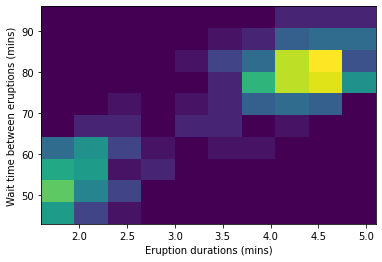

In [3]:
plt.hist2d(er, waits, alpha=1.0)
plt.xlabel("Eruption durations (mins)")
plt.ylabel("Wait time between eruptions (mins)");

In [4]:
data = np.concatenate([er.reshape(-1, 1), waits.reshape(-1, 1)], 1)
theta = em_gaussian_mixture(data, 2, 1000)
theta

Theta(mu=[array([ 2.03638845, 54.47851638]), array([ 4.28966197, 79.96811517])], sigma=[array([[ 0.06916767,  0.43516762],
       [ 0.43516762, 33.69728207]]), array([[ 0.16996844,  0.94060932],
       [ 0.94060932, 36.04621132]])], gamma=array([0.35587286, 0.64412714]))

In [5]:
import torch
import torch.nn as nn
import torch.utils.data as tdata
from vaes_ptorch import VAE, GaussianMLP, TrainArgs, train
from vaes_ptorch.args import DivAnnealing

In [6]:
def scale_data(data):  # of shape n, p
    mean_, std_ = data.mean(0), data.std(0)
    return (data - mean_) / std_, (mean_, std_)


def rescale_data(data, mean_std):
    mean_, std_ = mean_std
    return mean_ + std_ * data

In [49]:
import numpy as np

data = np.asarray([10.0, -10.0]).reshape(-1, 1)
data

array([[ 10.],
       [-10.]])

In [69]:
data_dim = 1
scale_data = False

latent_dim = 1
h_size = 16
h_layers = 5

lr = 1e-3
batch_size = 128
num_epochs = 1000

print_every = 100

info_vae = True

start_scale = 100.0
end_scale = 100.00
start_epochs = 100
linear_epochs = 100

In [70]:
if scale_data:
    scaled, mean_std = scale_data(data)
else:
    scaled, mean_std = data, (0.0, 1.0)
dataset = tdata.TensorDataset(torch.from_numpy(scaled).float())
dataloader = tdata.DataLoader(
    dataset=dataset, batch_size=batch_size, shuffle=True
)

In [71]:
encoder = GaussianMLP(
    in_dim=data_dim, h_dims=[h_size] * h_layers, out_dim=latent_dim
)
decoder = GaussianMLP(
    in_dim=latent_dim, h_dims=[h_size] * h_layers, out_dim=data_dim
)
vae = VAE(encoder=encoder, decoder=decoder)
optimizer = torch.optim.Adam(params=vae.parameters(), lr=lr)
train_args = TrainArgs(
    info_vae=info_vae,
    num_epochs=num_epochs,
    div_annealing=DivAnnealing(
        start_epochs=start_epochs,
        linear_epochs=linear_epochs,
        start_scale=start_scale,
        end_scale=end_scale,
    ),
    print_every=print_every,
    smoothing=0.9,
)

In [72]:
train(data=dataloader, vae=vae, optimizer=optimizer, args=train_args)

Step: 0 | Loss: 103.32794 | Div scale: 100.000
NLL: 50.00454 | MMD-div: 0.53323
Step: 100 | Loss: 76.75411 | Div scale: 100.000
NLL: 9.85164 | MMD-div: 0.00880
Step: 200 | Loss: 39.29530 | Div scale: 100.000
NLL: 2.80461 | MMD-div: 0.35983
Step: 300 | Loss: 38.46264 | Div scale: 100.000
NLL: 2.79996 | MMD-div: 0.18820
Step: 400 | Loss: 42.43368 | Div scale: 100.000
NLL: 2.79969 | MMD-div: 0.35825
Step: 500 | Loss: 36.03641 | Div scale: 100.000
NLL: 2.79908 | MMD-div: 0.52883
Step: 600 | Loss: 28.13475 | Div scale: 100.000
NLL: 2.79923 | MMD-div: 0.28767
Step: 700 | Loss: 46.56131 | Div scale: 100.000
NLL: 2.79933 | MMD-div: 0.66204
Step: 800 | Loss: 42.51174 | Div scale: 100.000
NLL: 2.79826 | MMD-div: 0.35739
Step: 900 | Loss: 31.93853 | Div scale: 100.000
NLL: 2.79853 | MMD-div: 0.35613


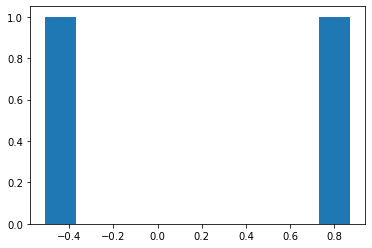

In [73]:
test = torch.from_numpy(scaled).float()
# TODO - better this
vae.eval()
with torch.no_grad():
    out = vae(test)
    z_samples = out.mu_z + torch.randn_like(out.mu_z) * torch.sqrt(out.sig_z)
    z_2d = z_samples.detach().numpy()
    try:
        plt.hist2d(z_2d[:, 0], z_2d[:, 1])
    except IndexError:
        plt.hist(z_2d)

tensor([[10.]])


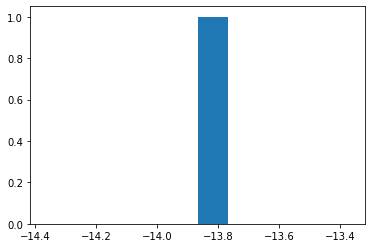

In [78]:
num_samples = 10
# TODO - better this
vae.eval()
with torch.no_grad():
    z_samples = torch.randn((num_samples, latent_dim))
    mu_x, sig_x = vae.decoder(z_samples)
    x_samples = mu_x + torch.randn_like(mu_x) * torch.sqrt(sig_x)
    x_2d = rescale_data(x_samples.detach().numpy(), mean_std)
    try:
        plt.hist2d(x_2d[:, 0], x_2d[:, 1])
    except IndexError:
        plt.hist(x_2d)

In [ ]:
# mu = torch.tensor([[1.0, -1.0,]])
# sig = torch.tensor([[2.0, 2.0]])
# t1 = np.linspace(0.1, 1.0)
# X, Y = np.meshgrid(t1, t1)
# Z = np.zeros_like(X)
# for i in range(t1.shape[0]):
#     for j in range(t1.shape[0]):
#         Z[i, j] += gaussian_kl(
#             left_mu=X[i, j] * mu,
#             left_sig=Y[i, j] * sig,
#             right_mu=torch.zeros_like(mu),
#             right_sig=torch.ones_like(sig),
#         )
#         Z[i, j] += nn.GaussianNLLLoss()(mu, X[i, j] * mu, Y[i, j] * sig)

# plt.contour(X, Y, Z, 20, cmap="RdGy")
# plt.colorbar()